In [601]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [602]:
rm_df = pd.read_csv("reverse_matching_20240213_eng.csv", encoding = "Windows-1252", sep=";")

In [603]:
rm_df.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"11,208",OFF_3435_4864,30.609745,99.309860,1,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Search and selection,secretary/secretary,Secretariat / General Services,TV
1,"11,208",ORD_13361_0218,42.466312,96.529259,1,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Employee (m/f),Secretariat / General Services,PN
2,"11,208",ORD_14183_0606,33.240650,95.374954,2,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Human Resources Officer (m/f),Human Resources / Recruitment,TV
3,"11,208",OFF_635_0402,58.744339,94.199844,2,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Search and selection,Telemarketing operator,Call Center / Customer Care,PD
4,"11,208",OFF_5814_0606,27.851854,93.688522,3,Female,25-34,VE,VENETO,"Master's Degree: Economics for arts, culture a...",Subordinate employment,Administrative Assistant,Finance / Accounting,TV


In [604]:
rm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193474 entries, 0 to 193473
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   cand_id                    193474 non-null  object 
 1   job_id                     193474 non-null  object 
 2   distance_km                193474 non-null  float64
 3   match_score                193474 non-null  float64
 4   match_rank                 193474 non-null  int64  
 5   cand_gender                193474 non-null  object 
 6   cand_age_bucket            193474 non-null  object 
 7   cand_domicile_province     190635 non-null  object 
 8   cand_domicile_region       193454 non-null  object 
 9   cand_education             70645 non-null   object 
 10  job_contract_type          193474 non-null  object 
 11  job_professional_category  192884 non-null  object 
 12  job_sector                 192876 non-null  object 
 13  job_work_province          16

cand_domicile_province has 190635 entries out of 193474 which means that there are missing ones. Same goes for cand_domicile_region, cand_education, job_professional_category, job_sector, job_work_province

In [605]:
print(rm_df.duplicated(subset=['cand_id', 'job_id']).sum())

0


In [606]:
#the null values are substituted with default values
rm_df['cand_education'] = rm_df['cand_education'].fillna('Not disclosed')
rm_df['job_professional_category'] = rm_df['job_professional_category'].fillna('Not disclosed')
rm_df['cand_domicile_province'] = rm_df['cand_domicile_province'].fillna('Not disclosed')
rm_df['cand_domicile_region'] = rm_df['cand_domicile_region'].fillna('Not disclosed')
rm_df['job_sector'] = rm_df['job_sector'].fillna('Not disclosed')
rm_df['job_work_province'] = rm_df['job_work_province'].fillna('Not disclosed')

In [608]:
rm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193474 entries, 0 to 193473
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   cand_id                    193474 non-null  object 
 1   job_id                     193474 non-null  object 
 2   distance_km                193474 non-null  float64
 3   match_score                193474 non-null  float64
 4   match_rank                 193474 non-null  int64  
 5   cand_gender                193474 non-null  object 
 6   cand_age_bucket            193474 non-null  object 
 7   cand_domicile_province     193474 non-null  object 
 8   cand_domicile_region       193474 non-null  object 
 9   cand_education             193474 non-null  object 
 10  job_contract_type          193474 non-null  object 
 11  job_professional_category  193474 non-null  object 
 12  job_sector                 193474 non-null  object 
 13  job_work_province          19

Irrelevant columns 

In [610]:
#columns_to_remove = ['cand_id']

### Feature mapping

1. Age

In [611]:
custom_order = ['15-24', '25-34', '35-44',
                '45-54', '55-74', 'blank']
rm_df['cand_age_bucket'] = pd.Categorical(rm_df['cand_age_bucket'], categories=custom_order, ordered=True)
     


Text(0, 0.5, 'Frequency')

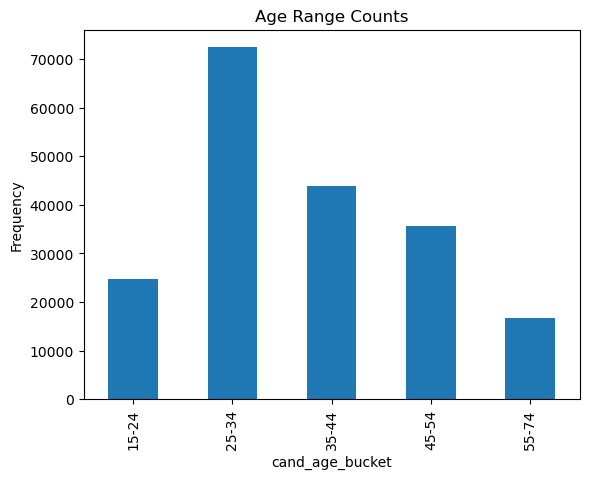

In [612]:

age_range_counts = Counter(rm_df['cand_age_bucket'].sort_values())
age_range_df = pd.DataFrame(age_range_counts.items(), columns=['cand_age_bucket', 'Count'])
age_range_df.plot(x='cand_age_bucket', y='Count', kind='bar', legend=False)
plt.title('Age Range Counts')
plt.ylabel('Frequency')
     

2. Sex

([<matplotlib.patches.Wedge at 0x19bdcca50>,
 [Text(-0.7201019230076691, -0.831536662138632, 'Female'),
  Text(0.7201020008617474, 0.8315365947178202, 'Male')],
 [Text(-0.3927828670950922, -0.4535654520756174, '49.5%'),
  Text(0.3927829095609531, 0.4535654153006291, '50.5%')])

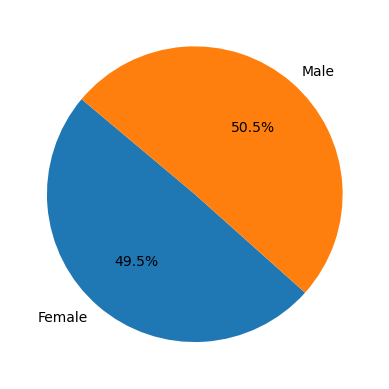

In [613]:
sex_distrib = Counter(rm_df['cand_gender'])
sex_distrib_df = pd.DataFrame(sex_distrib.items(), columns=['cand_gender', 'Count'])

labels = sex_distrib_df['cand_gender']
sizes = sex_distrib_df['Count']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

From the pie chart we can see that the distribution between male and female is almost equal, which means that there is close to zero bias regarding the gender

3. Dominicile Region

In [614]:
unique_values = rm_df['cand_domicile_region'].unique()
print("Unique values in canidates domicile region column:", unique_values)

Unique values in canidates domicile region column: ['VENETO' 'LOMBARDIA' 'EMILIA ROMAGNA' 'TRENTINO ALTO ADIGE' 'PIEMONTE'
 'TOSCANA' 'MARCHE' 'PUGLIA' 'MOLISE' 'ABRUZZO' 'FRIULI VENEZIA GIULIA'
 'UMBRIA' 'LAZIO' 'LIGURIA' 'BASILICATA' 'SICILIA' 'CAMPANIA'
 "VALLE D'AOSTA" 'SARDEGNA' 'CALABRIA' 'Not disclosed']


In [615]:
# Count occurrences of each region in percentage
region_counts = rm_df['cand_domicile_region'].value_counts(normalize=True) * 100
print("Percentage distribution of domicile regions: \n", region_counts)

Percentage distribution of domicile regions: 
 LOMBARDIA                32.819914
PIEMONTE                 12.465241
VENETO                   11.851205
EMILIA ROMAGNA           11.153954
LAZIO                     7.864623
TOSCANA                   6.018897
ABRUZZO                   2.858265
FRIULI VENEZIA GIULIA     2.808646
CAMPANIA                  2.629811
MARCHE                    2.171868
TRENTINO ALTO ADIGE       1.714959
PUGLIA                    1.695318
LIGURIA                   1.523202
UMBRIA                    0.787186
SICILIA                   0.545810
MOLISE                    0.394885
SARDEGNA                  0.316838
VALLE D'AOSTA             0.181937
BASILICATA                0.127149
CALABRIA                  0.059956
Not disclosed             0.010337
Name: cand_domicile_region, dtype: float64


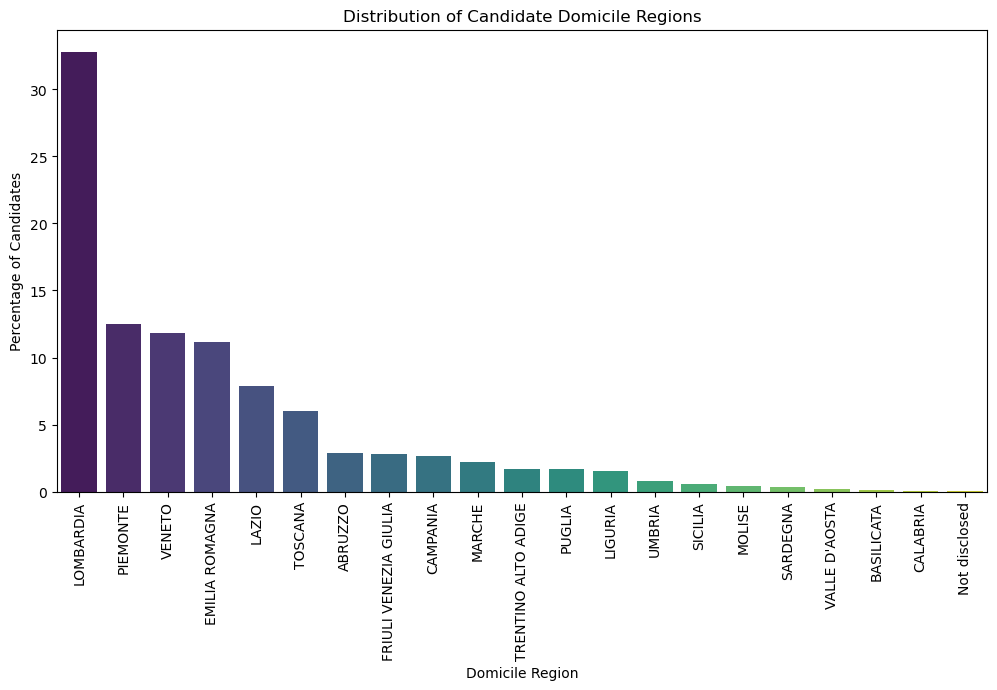

In [616]:

# Plot the frequency of each domicile region
plt.figure(figsize=(12, 6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette="viridis")

# Customize the plot
plt.xlabel("Domicile Region")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Candidate Domicile Regions")
plt.xticks(rotation=90)  # Rotate for better readability
plt.show()


From the plot we can see that the most candidates come from the Lombardy region and in general the ones that are from south of Italy are less

4. Dominicile Province

In [617]:
unique_values = rm_df['cand_domicile_province'].unique()
print("Unique values in canidates domicile province column:", unique_values)

Unique values in canidates domicile province column: ['VE' 'BS' 'PR' 'RE' 'TN' 'BO' 'MI' 'TO' 'PI' 'CO' 'CR' 'MB' 'SI' 'PU'
 'TA' 'CB' 'CH' 'MO' 'PD' 'GO' 'FE' 'PG' 'BG' 'PV' 'VR' 'VI' 'LT' 'RM'
 'GE' 'NO' 'AL' 'TV' 'PO' 'AT' 'SO' 'PZ' 'AN' 'PC' 'BR' 'PT' 'FI' 'RO'
 'AQ' 'AR' 'BZ' 'LI' 'VC' 'MS' 'BI' 'PA' 'CN' 'Not disclosed' 'MN' 'BA'
 'LC' 'UD' 'ME' 'FR' 'FC' 'PN' 'AO' 'AV' 'SV' 'LU' 'VA' 'SA' 'BL' 'CT'
 'TS' 'LO' 'CE' 'MC' 'EN' 'CL' 'TE' 'VB' 'LE' 'VT' 'FM' 'RN' 'FG' 'RI'
 'AP' 'PE' 'SP' 'BN' 'SR' 'CA' 'SS' 'RC' 'RG' 'IS' 'RA' 'BT' 'MT' 'IM'
 'TP' 'SU' 'TR' 'AG' 'GR' 'CS' 'CZ' 'OR' 'NU' 'VV' 'SC' 'KR']


In [618]:
# Count occurrences of each region in percentage
province_counts = rm_df['cand_domicile_province'].value_counts(normalize=True) * 100
print("Percentage distribution of domicile province: \n", province_counts)

Percentage distribution of domicile province: 
 MI    10.810755
TO     7.034537
RM     5.485492
BG     4.551516
BS     3.992785
        ...    
CZ     0.009820
VV     0.007753
SC     0.005169
EN     0.002067
KR     0.001034
Name: cand_domicile_province, Length: 108, dtype: float64


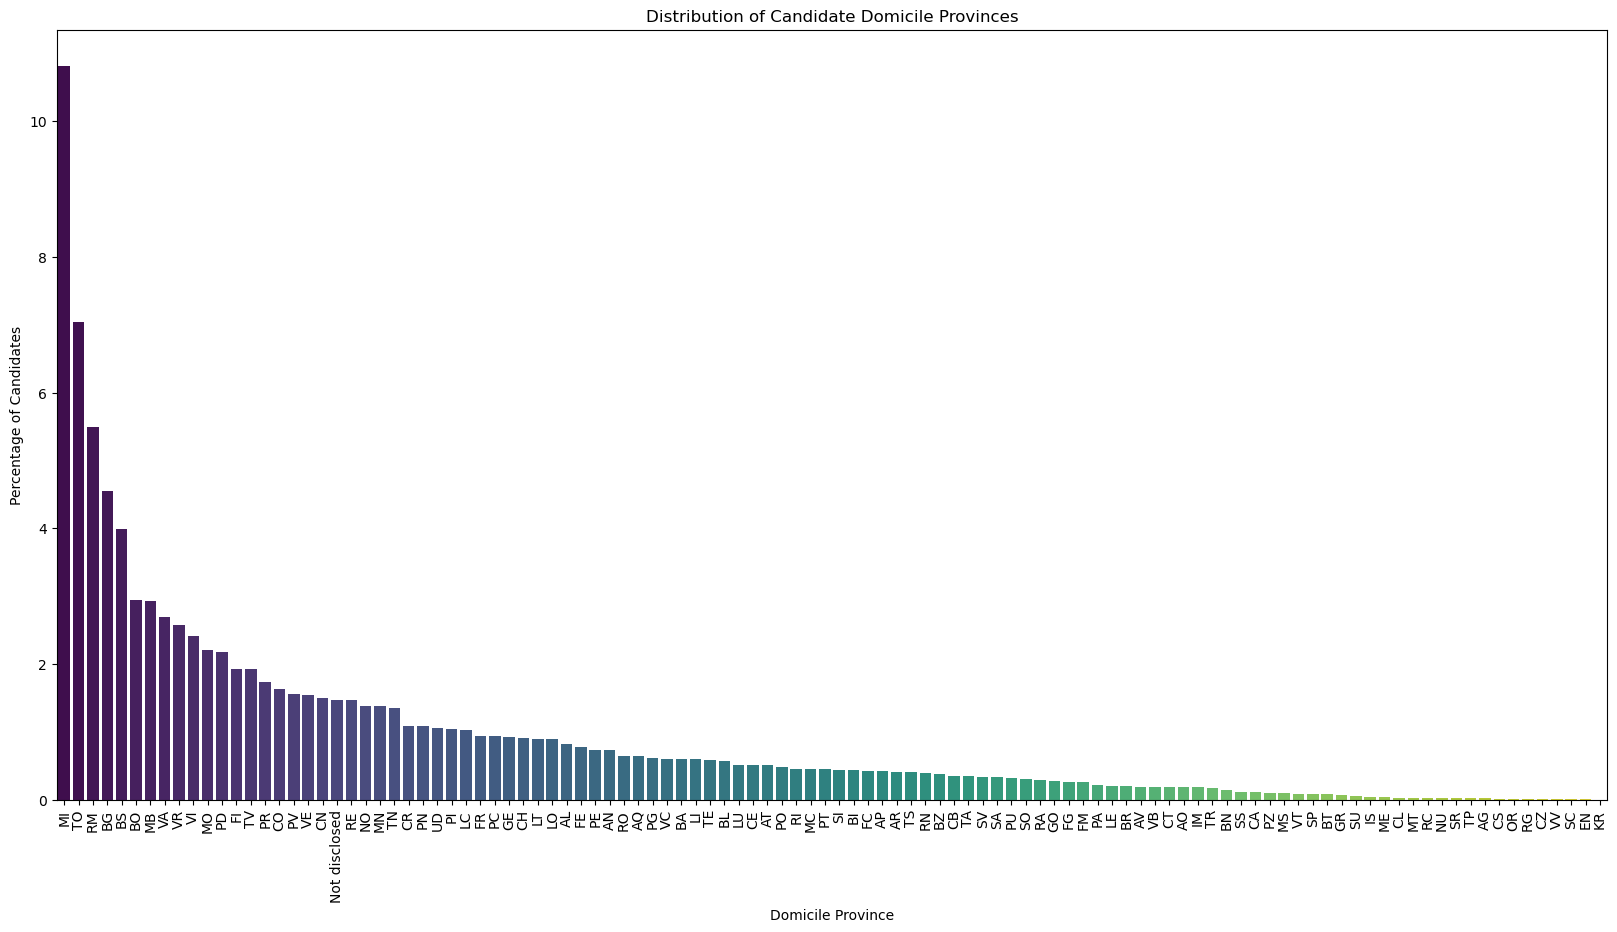

In [619]:
# Plot the frequency of each domicile region
plt.figure(figsize=(20, 10))
sns.barplot(x=province_counts.index, y=province_counts.values, palette="viridis")

# Customize the plot
plt.xlabel("Domicile Province")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Candidate Domicile Provinces")
plt.xticks(rotation=90)  
plt.show()


#### Job Work Province

In [620]:
# Count occurrences of each region in percentage
job_province_counts = rm_df['job_work_province'].value_counts(normalize=True) * 100
print("Percentage distribution of job province: \n", job_province_counts)

Percentage distribution of job province: 
 MI               17.443688
Not disclosed    12.328788
RM                6.075235
TO                6.047324
BG                4.418682
                   ...    
CS                0.003101
OG                0.001034
CZ                0.001034
OR                0.000517
EN                0.000517
Name: job_work_province, Length: 108, dtype: float64


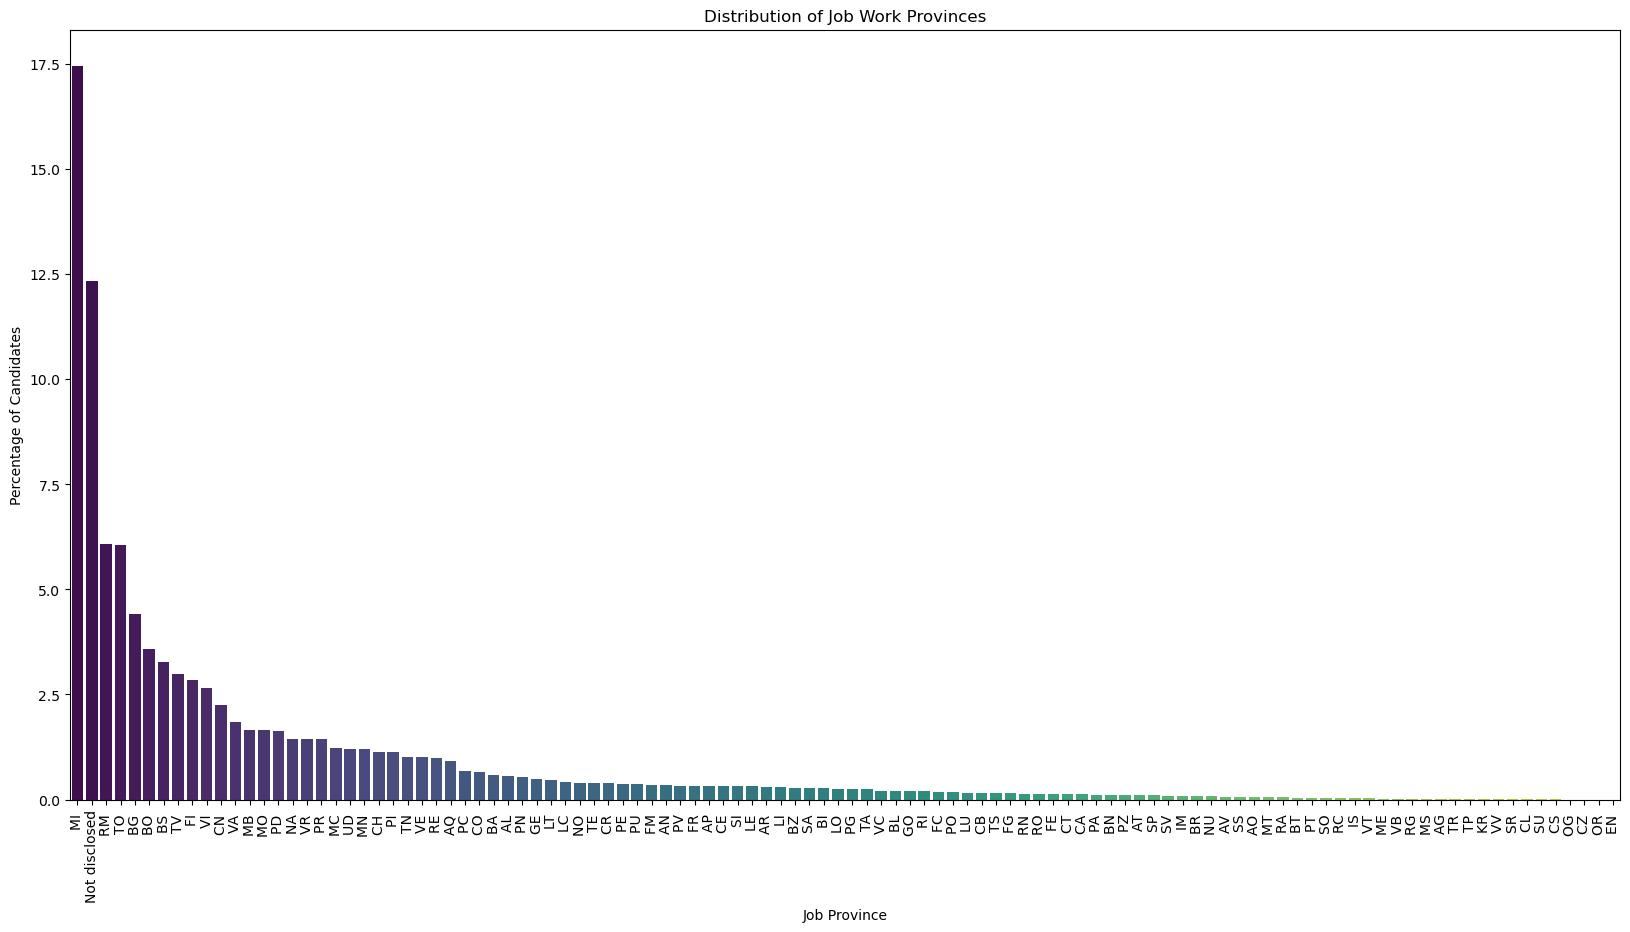

In [621]:
plt.figure(figsize=(20, 10))
sns.barplot(x=job_province_counts.index, y=job_province_counts.values, palette="viridis")

plt.xlabel("Job Province")
plt.ylabel("Percentage of Candidates")
plt.title("Distribution of Job Work Provinces")
plt.xticks(rotation=90)  
plt.show()

#### Education

In [622]:
print(f"There are {len(rm_df['cand_education'].unique())} different  values:\n {rm_df['cand_education'].unique()} \n")
     

There are 1678 different  values:
 ["Master's Degree: Economics for arts, culture and communication"
 'Not disclosed' 'Diploma / Academy: Accountant and programmer' ...
 "Bachelor's Degree: Communication Sciences (L-20); Master's Degree: Entertainment Sciences and Multimedia Production (LM-65)"
 "Master's Degree: Linguistics (LM-39); University Master's Degree: Humanistic/Social Master's Degree"
 'Qualification / Certificate: Sales clerk; Qualification / Certificate: Office operator; Qualification / Certificate: Tourism company operator; Diploma / Academy: Accounting'] 



In [623]:
study_areas_counts = Counter(rm_df['cand_education'])

study_areas_counts_df = pd.DataFrame(study_areas_counts.items(), columns=['cand_education', 'Count'])
study_areas_counts_df = study_areas_counts_df.sort_values(by='Count', ascending=False)

study_areas_counts_df.head(10)

,cand_education,Count
1,Not disclosed,122829
5,Middle School diploma,5464
3,Diploma / Academy: Accounting,4683
33,Diploma / Academy: Scientific high school,2607
25,Diploma / Academy: Surveyor,1549
74,Higher Technical Institute (ITS): Other,1398
4,Diploma / Academy: Business Administration,1334
24,Diploma / Academy: Linguistic high school,1271
47,Diploma / Academy: Expert in Electronics and E...,1003
28,Diploma / Academy: Service technician for food...,968


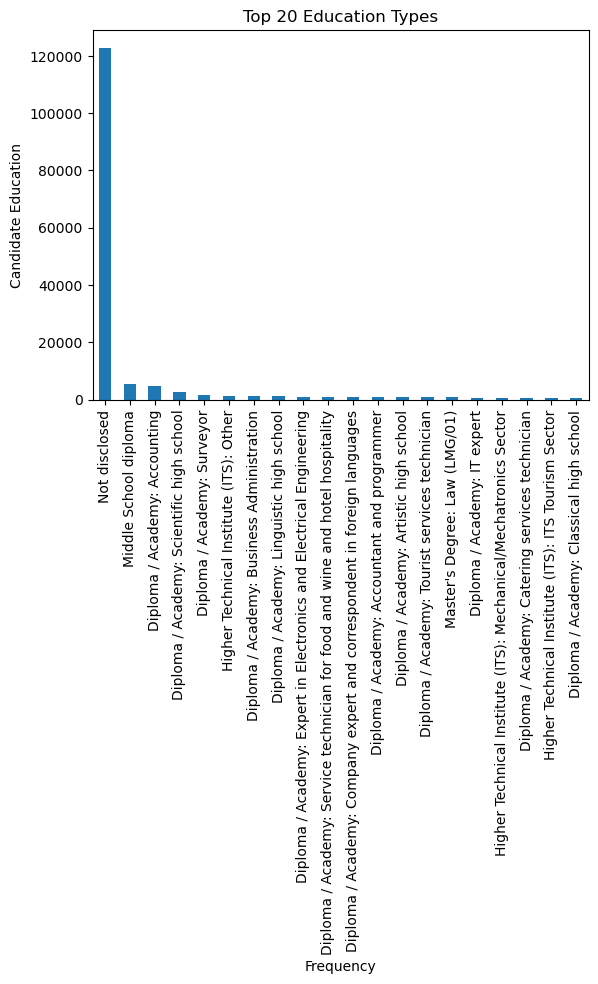

In [624]:
study_areas_counts_df.head(20).plot(x='cand_education', y='Count', kind='bar', legend=False)
plt.title('Top 20 Education Types')
plt.xlabel('Frequency')
plt.ylabel('Candidate Education')
plt.show()

### Job contract type vs gender


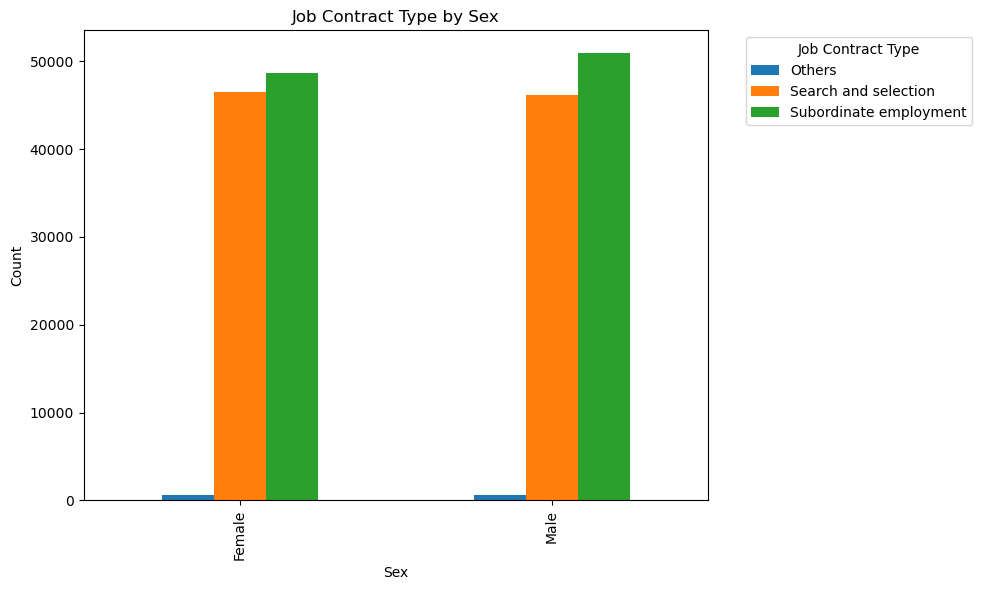

In [625]:

pivot = rm_df.pivot_table(index='cand_gender', columns='job_contract_type', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Job Contract Type by Sex')
plt.ylabel('Count')
plt.xlabel('Sex')
plt.legend(title='Job Contract Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

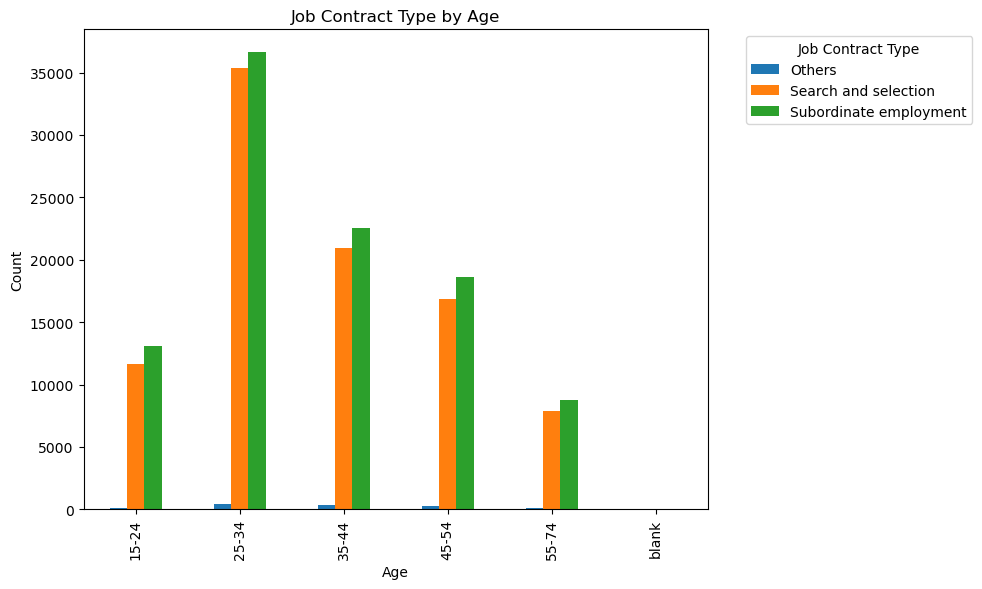

In [626]:
pivot = rm_df.pivot_table(index='cand_age_bucket', columns='job_contract_type', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Job Contract Type by Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.legend(title='Job Contract Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Job Sector vs Gender

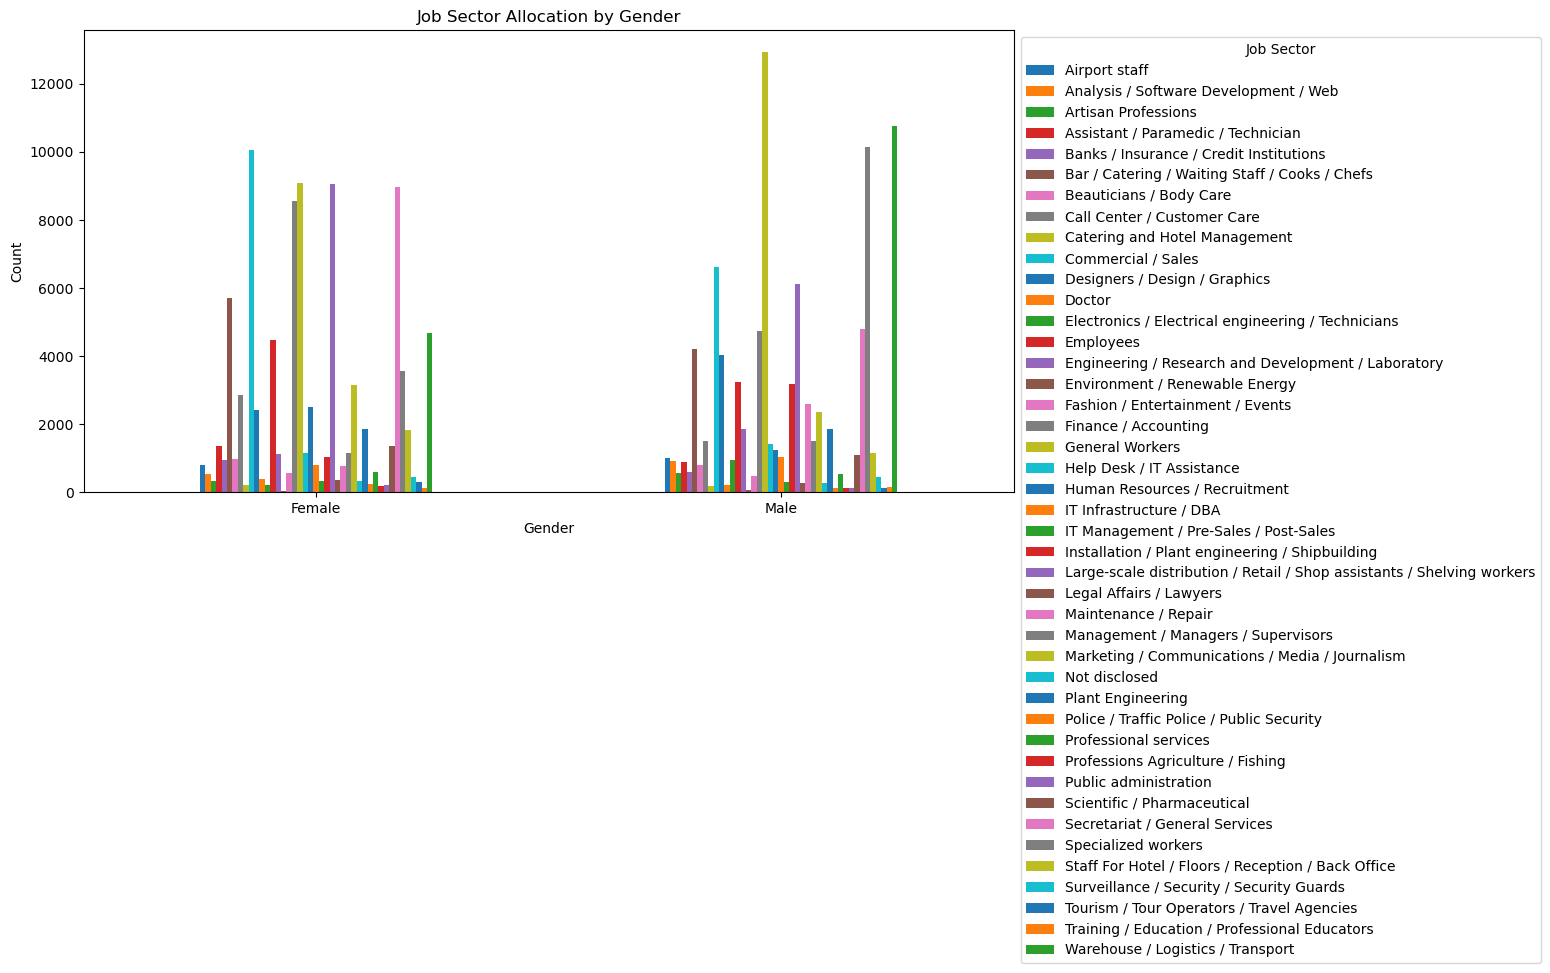

job_sector   Airport staff  Analysis / Software Development / Web  \
cand_gender                                                         
Female                 793                                    527   
Male                  1001                                    923   

job_sector   Artisan Professions  Assistant / Paramedic / Technician  \
cand_gender                                                            
Female                       347                                1359   
Male                         562                                 897   

job_sector   Banks / Insurance / Credit Institutions  \
cand_gender                                            
Female                                           951   
Male                                             598   

job_sector   Bar / Catering / Waiting Staff / Cooks / Chefs  \
cand_gender                                                   
Female                                                 5715   
Male                

In [627]:

# Count the occurrences of each job sector per gender
job_sector_counts = rm_df.groupby(["cand_gender", "job_sector"]).size().unstack(fill_value=0)

job_sector_counts.plot(kind="bar", figsize=(12, 6))
plt.title("Job Sector Allocation by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Job Sector", bbox_to_anchor=(1, 1))
plt.show()

print(job_sector_counts)



### Top 5 job sectors by gender

In [628]:
# Count occurrences of each job sector per gender
job_sector_counts = rm_df.groupby(["cand_gender", "job_sector"]).size().reset_index(name="count")

# Get the top 5 job sectors for each gender
top5_job_sectors = job_sector_counts.groupby("cand_gender").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)

print(top5_job_sectors)


  cand_gender                                         job_sector  count
0      Female                                 Commercial / Sales  10046
1      Female                                    General Workers   9077
2      Female  Large-scale distribution / Retail / Shop assis...   9058
3      Female                     Secretariat / General Services   8983
4      Female                              Finance / Accounting    8569
5        Male                                    General Workers  12927
6        Male                  Warehouse / Logistics / Transport  10777
7        Male                                Specialized workers  10150
8        Male                                 Commercial / Sales   6624
9        Male  Large-scale distribution / Retail / Shop assis...   6133


### Gender vs Match Rank

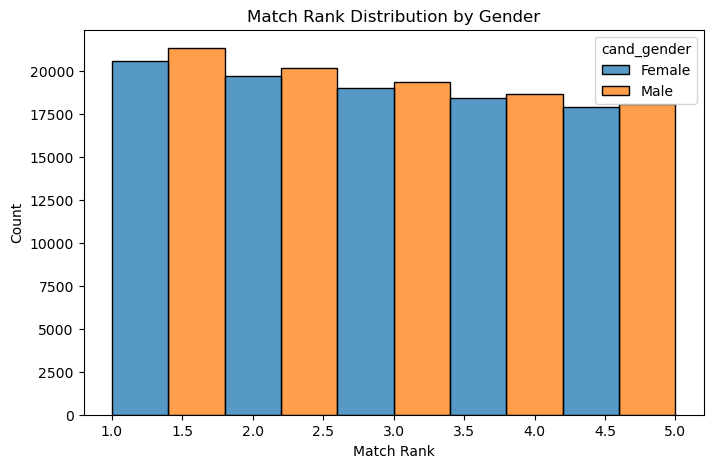

In [629]:
plt.figure(figsize=(8, 5))
sns.histplot(data=rm_df, x="match_rank", hue="cand_gender", multiple="dodge", bins=5)
plt.title("Match Rank Distribution by Gender")
plt.xlabel("Match Rank")
plt.ylabel("Count")
plt.show()

### Age vs Match Rank

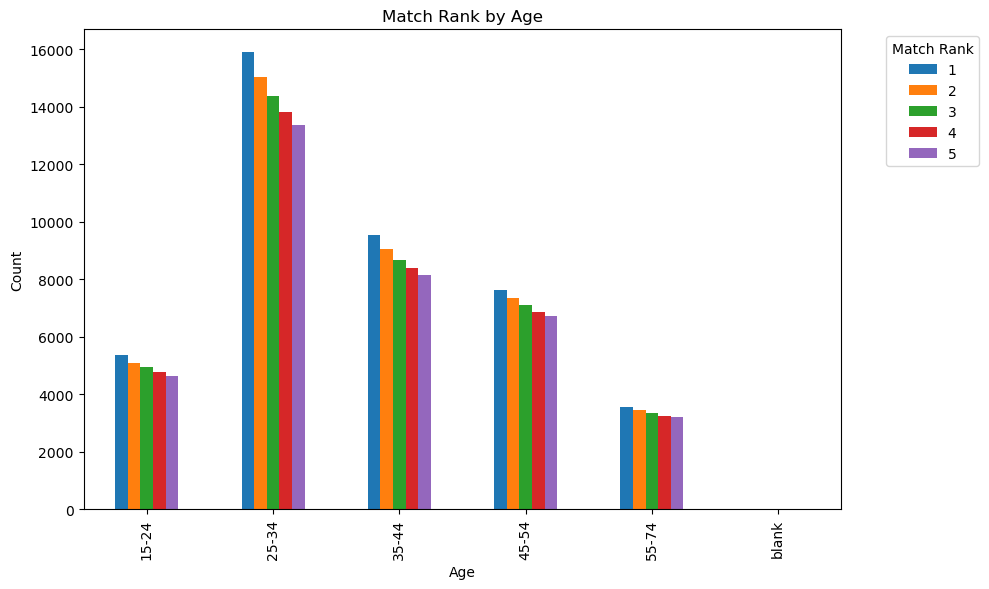

In [630]:
pivot = rm_df.pivot_table(index='cand_age_bucket', columns='match_rank', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Match Rank by Age')
plt.ylabel('Count')
plt.xlabel('Age')
plt.legend(title='Match Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Candidate Domicile Region vs Match Rank

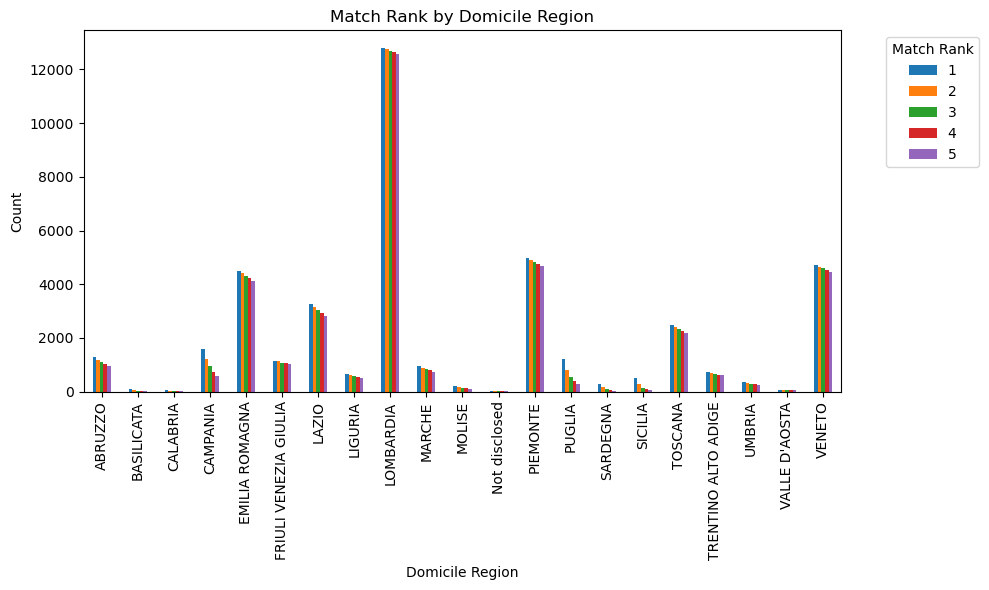

In [631]:
pivot = rm_df.pivot_table(index='cand_domicile_region', columns='match_rank', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Match Rank by Domicile Region')
plt.ylabel('Count')
plt.xlabel('Domicile Region')
plt.legend(title='Match Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Gender vs. Job Type Distribution (Offers vs. Orders)

The dataset contains the 5 best offers and orders:
Job positions published on the Adecco website and job positions managed internally

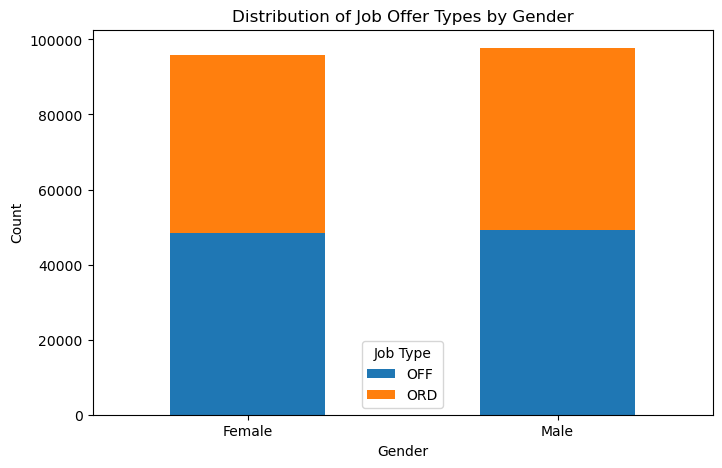

In [632]:
# Extract job type prefix
rm_df["job_type"] = rm_df["job_id"].apply(lambda x: "OFF" if x.startswith("OFF_") else ("ORD" if x.startswith("ORD_") else None))

# Filter relevant job types
df_filtered = rm_df[rm_df["job_type"].notna()]

# Count occurrences per gender and job type
job_counts = df_filtered.groupby(["cand_gender", "job_type"]).size().unstack(fill_value=0)

job_counts.plot(kind="bar", stacked=True, figsize=(8, 5))
plt.title("Distribution of Job Offer Types by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Job Type")
plt.show()

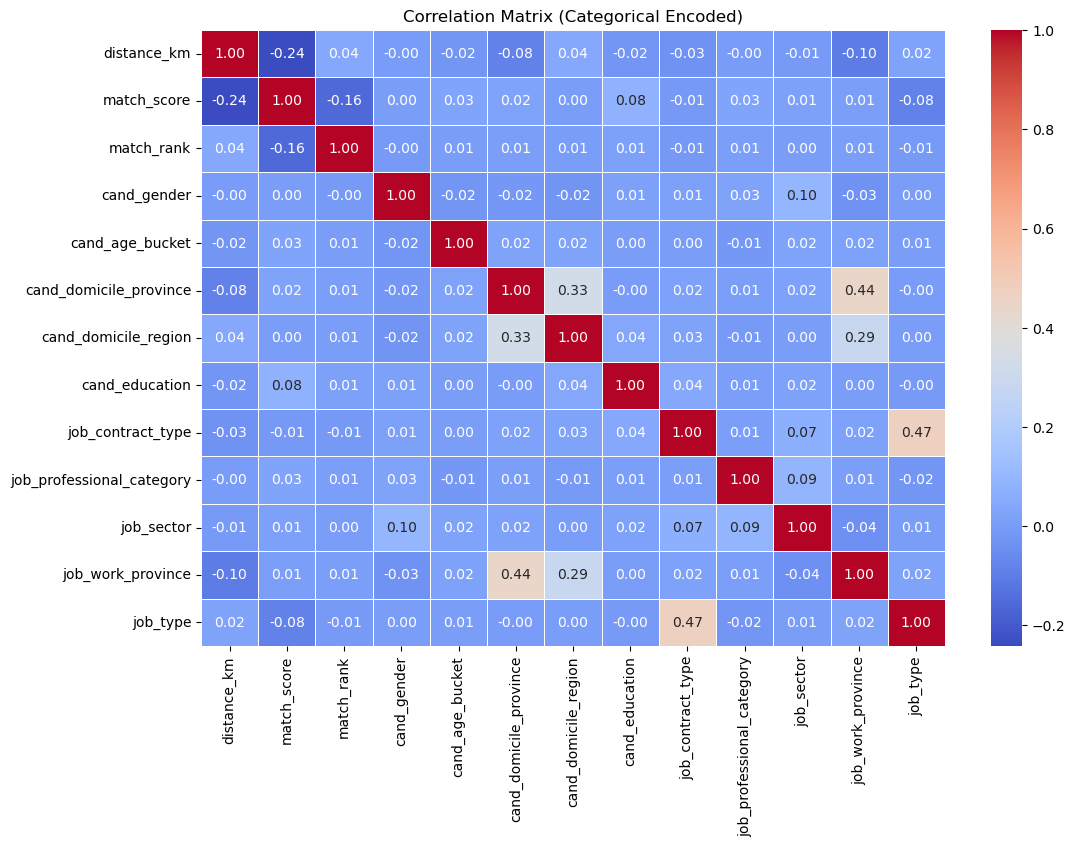

In [633]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns (excluding `cand_id` and `job_id` since they are unique identifiers)
categorical_columns = [
    "cand_gender", "cand_age_bucket", "cand_domicile_province",
    "cand_domicile_region", "cand_education", "job_contract_type",
    "job_professional_category", "job_sector", "job_work_province", "job_type"
]

# Apply Label Encoding for categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    rm_df[col] = le.fit_transform(rm_df[col])  
    label_encoders[col] = le

rm_df = rm_df.drop('cand_id', axis=1)
rm_df = rm_df.drop('job_id', axis=1)

# Compute the correlation matrix
correlation_matrix = rm_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Categorical Encoded)")
plt.show()


# AI Fairness 360 
## Bias Detection

In [634]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

### 1. Detect Gender Bias w.r.t. match score

In [635]:
# Retrieve the mapping from LabelEncoder
gender_label_mapping = {index: label for index, label in enumerate(label_encoders["cand_gender"].classes_)}

print("Label Encoding Mapping for gender:", gender_label_mapping)

Label Encoding Mapping for gender: {0: 'Female', 1: 'Male'}


In [636]:
df = rm_df.copy()

# Ensure gender codes are integers
df["cand_gender"] = df["cand_gender"].astype(int)

# Define the target variable (match score threshold for fairness)
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  # 1 if match_score ≥ 80

# Keep only necessary columns
df = df[["cand_gender", "favorable_outcome"]]

# Define protected attribute
protected_attribute = "cand_gender"  

In [637]:
# Convert dataframe into AIF360 dataset
aif_dataset = StandardDataset(
    df,
    label_name="favorable_outcome",  # The target variable
    favorable_classes=[1],  # Match scores >= 80 are considered favorable
    protected_attribute_names=[protected_attribute],  
    privileged_classes=[[0]]  # Female (0) is privileged, male (1) is unprivileged
)

# Compute fairness metrics
metric = BinaryLabelDatasetMetric(
    aif_dataset, 
    privileged_groups=[{protected_attribute: 0}],  
    unprivileged_groups=[{protected_attribute: 1}]  
)



In [638]:
print(f"Disparate Impact: {metric.disparate_impact()}")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference()}")
print(f"Mean Difference: {metric.mean_difference()}")

Disparate Impact: 0.9966378609367027
Statistical Parity Difference: -0.0030056634406304683
Mean Difference: -0.0030056634406304683


1. Diasparate Impact: 
- measure whether the positive outcome rate (match score >= 80) is similar for unpriviledged (male) and privilidged (female) groups
- Score that equals 1 means that there is no bias, they are treated equally
- In our case, the result we have obtained is 0.996 -> almost 1 -> no bias
2. Statistical Parity Difference:
- measures the absolute difference in positive outcome rates between the unprivileged (male) and privileged (female) groups
- Score that equals to 0 means there is no bias
- In our case, the result we have obtained is: -0.003, very close to 0 meaning that gender has little to no effect on match score distribution
3. Mean Difference:
- Similar to SPD, but measured as a direct mean difference in positive outcomes
- Score that equals to 0 means there is no bias
- In our case, the result we have obtained is: -0.003, very close to 0 meaning that gender has little to no effect in avg match score outcomes


### 2. Detect Age Bias w.r.t. match score

In [639]:
# Retrieve the mapping from LabelEncoder
age_label_mapping = {index: label for index, label in enumerate(label_encoders["cand_age_bucket"].classes_)}

print("Label Encoding Mapping for age:", age_label_mapping)

Label Encoding Mapping for age: {0: '15-24', 1: '25-34', 2: '35-44', 3: '45-54', 4: '55-74'}


In [640]:
df = rm_df.copy()

# Ensure age bucket codes are integers
df["cand_age_bucket"] = df["cand_age_bucket"].astype(int)

# Define the target variable (match score threshold for fairness)
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  # 1 if match_score ≥ 80

# Keep only necessary columns
df = df[["cand_age_bucket", "favorable_outcome"]]

In [641]:
# Define privileged age group (25-34)
privileged_age = [1]  

# Convert dataframe into AIF360 dataset
aif_dataset = StandardDataset(
    df,
    label_name="favorable_outcome",
    favorable_classes=[1],  
    protected_attribute_names=["cand_age_bucket"],  
    privileged_classes=[privileged_age]  
)


In [642]:
# Get all age groups except 25-34
all_ages = df["cand_age_bucket"].unique()
unprivileged_ages = [{"cand_age_bucket": r} for r in all_ages if r != 1]

# Store results in a dictionary
fairness_results = []

for age in unprivileged_ages:
    metric = BinaryLabelDatasetMetric(
        aif_dataset, 
        privileged_groups=[{"cand_age_bucket": 1}],  
        unprivileged_groups=[age]
    )
    
    fairness_results.append({
        "Age Bucket": age["cand_age_bucket"],
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference()
    })


In [643]:
print(fairness_results)

[{'Age Bucket': 4, 'Disparate Impact': 1.0304406971793534, 'Statistical Parity Difference': 0.026919872795473476}, {'Age Bucket': 2, 'Disparate Impact': 1.0070218581513424, 'Statistical Parity Difference': 0.006209697731568542}, {'Age Bucket': 3, 'Disparate Impact': 1.0211388861559054, 'Statistical Parity Difference': 0.018693925536663825}, {'Age Bucket': 0, 'Disparate Impact': 1.0082261010113216, 'Statistical Parity Difference': 0.007274655751895565}]


In [644]:
# Convert to DataFrame for visualization
fairness_df = pd.DataFrame(fairness_results)

# Fill missing fairness values to avoid errors
fairness_df = fairness_df.fillna(0)

# Sort age groups for better visualization
fairness_df = fairness_df.sort_values(by="Disparate Impact")

age_label_mapping = {
    0: '15-24', 1: '25-34', 2: '35-44', 3: '45-54', 4: '55-74'}


# Map age group numbers to names & fill missing values
fairness_df["Age Bucket"] = fairness_df["Age Bucket"].map(age_label_mapping).fillna("Unknown Age")

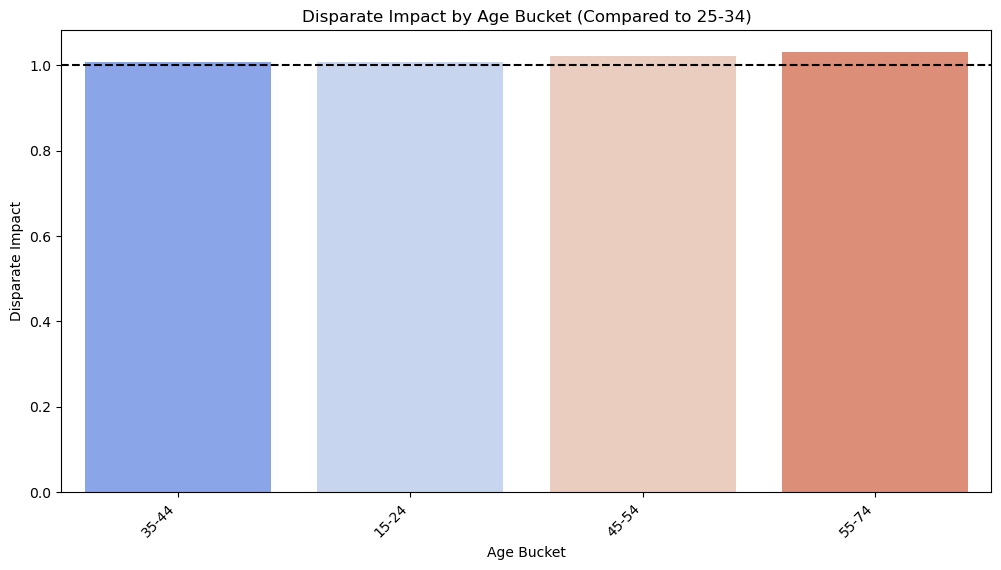

In [645]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Age Bucket", y="Disparate Impact", data=fairness_df, palette="coolwarm")
plt.axhline(y=1, color="black", linestyle="--")  
plt.xlabel("Age Bucket")
plt.ylabel("Disparate Impact")
plt.title("Disparate Impact by Age Bucket (Compared to 25-34)")
plt.xticks(rotation=45, ha="right")  
plt.show()

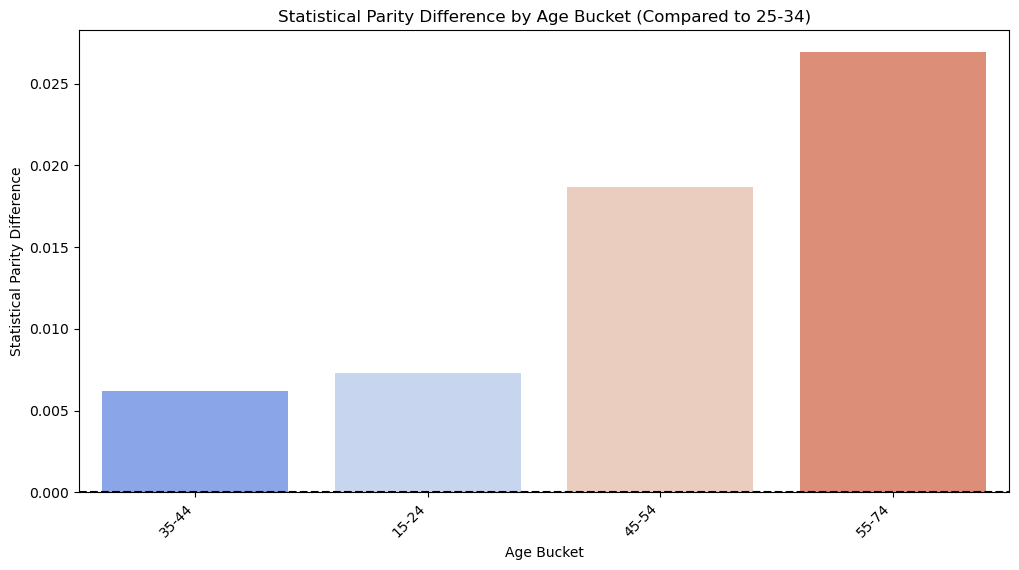

In [646]:
fairness_df = fairness_df.sort_values(by="Statistical Parity Difference")

plt.figure(figsize=(12, 6))
sns.barplot(x="Age Bucket", y="Statistical Parity Difference", data=fairness_df, palette="coolwarm")
plt.axhline(y=0, color="black", linestyle="--")  
plt.xlabel("Age Bucket")
plt.ylabel("Statistical Parity Difference")
plt.title("Statistical Parity Difference by Age Bucket (Compared to 25-34)")
plt.xticks(rotation=45, ha="right")  
plt.show()

### 3. Detect Region Bias w.r.t. Match score

In [647]:
# Retrieve the mapping from LabelEncoder
region_label_mapping = {index: label for index, label in enumerate(label_encoders["cand_domicile_region"].classes_)}

print("Label Encoding Mapping for Regions:", region_label_mapping)


Label Encoding Mapping for Regions: {0: 'ABRUZZO', 1: 'BASILICATA', 2: 'CALABRIA', 3: 'CAMPANIA', 4: 'EMILIA ROMAGNA', 5: 'FRIULI VENEZIA GIULIA', 6: 'LAZIO', 7: 'LIGURIA', 8: 'LOMBARDIA', 9: 'MARCHE', 10: 'MOLISE', 11: 'Not disclosed', 12: 'PIEMONTE', 13: 'PUGLIA', 14: 'SARDEGNA', 15: 'SICILIA', 16: 'TOSCANA', 17: 'TRENTINO ALTO ADIGE', 18: 'UMBRIA', 19: "VALLE D'AOSTA", 20: 'VENETO'}


In [648]:
df = rm_df.copy()

# Ensure region codes are integers
df["cand_domicile_region"] = df["cand_domicile_region"].astype(int)

# Define the target variable (match score threshold for fairness)
df["favorable_outcome"] = (df["match_score"] >= 80).astype(int)  # 1 if match_score ≥ 80

# Keep only necessary columns
df = df[["cand_domicile_region", "favorable_outcome"]]

In [649]:
# Define privileged region (Lombardia = 8)
privileged_region = [8]  

# Convert dataframe into AIF360 dataset
aif_dataset = StandardDataset(
    df,
    label_name="favorable_outcome",
    favorable_classes=[1],  
    protected_attribute_names=["cand_domicile_region"],  
    privileged_classes=[privileged_region]  
)


In [650]:
# Get all regions except Lombardia
all_regions = df["cand_domicile_region"].unique()
unprivileged_regions = [{"cand_domicile_region": r} for r in all_regions if r != 8]

fairness_results = []

for region in unprivileged_regions:
    metric = BinaryLabelDatasetMetric(
        aif_dataset, 
        privileged_groups=[{"cand_domicile_region": 8}], 
        unprivileged_groups=[region]
    )
    
    fairness_results.append({
        "Region": region["cand_domicile_region"],
        "Disparate Impact": metric.disparate_impact(),
        "Statistical Parity Difference": metric.statistical_parity_difference()
    })


In [651]:
print(fairness_results)

[{'Region': 20, 'Disparate Impact': 0.9394368146049057, 'Statistical Parity Difference': -0.05829604797841759}, {'Region': 4, 'Disparate Impact': 0.9103045571540517, 'Statistical Parity Difference': -0.08633776122377412}, {'Region': 17, 'Disparate Impact': 0.8591664718190251, 'Statistical Parity Difference': -0.13556153069308274}, {'Region': 12, 'Disparate Impact': 0.9567851455914006, 'Statistical Parity Difference': -0.04159713874937798}, {'Region': 16, 'Disparate Impact': 0.9121178257581942, 'Statistical Parity Difference': -0.08459237096969052}, {'Region': 9, 'Disparate Impact': 0.8111847504432516, 'Statistical Parity Difference': -0.1817470923203569}, {'Region': 13, 'Disparate Impact': 0.6622924199538619, 'Statistical Parity Difference': -0.3250657501023655}, {'Region': 10, 'Disparate Impact': 0.6363881583788265, 'Statistical Parity Difference': -0.3500003050761874}, {'Region': 0, 'Disparate Impact': 0.8380630388013128, 'Statistical Parity Difference': -0.15587497252551197}, {'Regi

In [652]:
# Convert to DataFrame for visualization
fairness_df = pd.DataFrame(fairness_results)

# Fill missing fairness values to avoid errors
fairness_df = fairness_df.fillna(0)

# Sort regions for better visualization
fairness_df = fairness_df.sort_values(by="Disparate Impact")

region_label_mapping = {
    0: 'ABRUZZO', 1: 'BASILICATA', 2: 'CALABRIA', 3: 'CAMPANIA', 4: 'EMILIA ROMAGNA',
    5: 'FRIULI VENEZIA GIULIA', 6: 'LAZIO', 7: 'LIGURIA', 8: 'LOMBARDIA', 9: 'MARCHE',
    10: 'MOLISE', 11: 'Not disclosed', 12: 'PIEMONTE', 13: 'PUGLIA', 14: 'SARDEGNA',
    15: 'SICILIA', 16: 'TOSCANA', 17: 'TRENTINO ALTO ADIGE', 18: 'UMBRIA', 19: "VALLE D'AOSTA", 20: 'VENETO'
}

# Map region numbers to names & fill missing values
fairness_df["Region"] = fairness_df["Region"].map(region_label_mapping).fillna("Unknown Region")

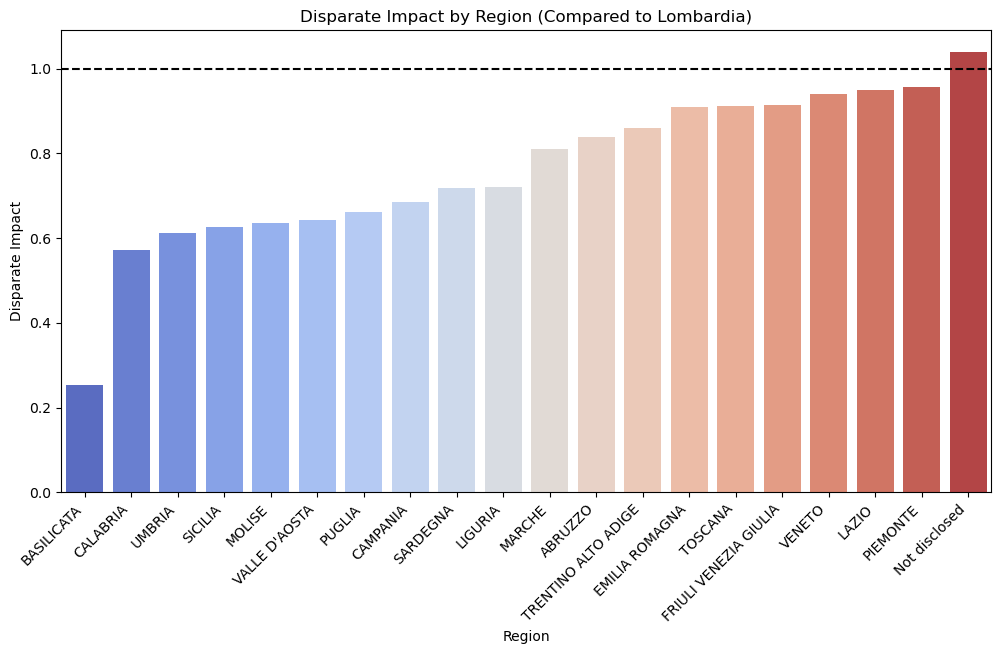

In [653]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Region", y="Disparate Impact", data=fairness_df, palette="coolwarm")
plt.axhline(y=1, color="black", linestyle="--")  
plt.xlabel("Region")
plt.ylabel("Disparate Impact")
plt.title("Disparate Impact by Region (Compared to Lombardia)")
plt.xticks(rotation=45, ha="right")  
plt.show()


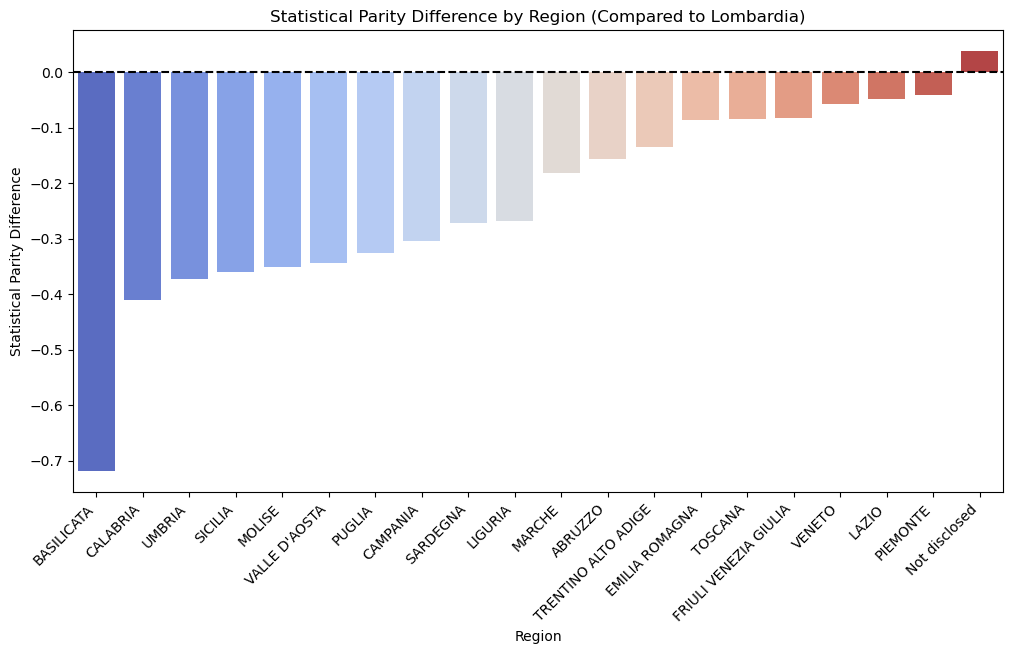

In [654]:
fairness_df = fairness_df.sort_values(by="Statistical Parity Difference")

plt.figure(figsize=(12, 6))
sns.barplot(x="Region", y="Statistical Parity Difference", data=fairness_df, palette="coolwarm")
plt.axhline(y=0, color="black", linestyle="--") 
plt.xlabel("Region")
plt.ylabel("Statistical Parity Difference")
plt.title("Statistical Parity Difference by Region (Compared to Lombardia)")
plt.xticks(rotation=45, ha="right")  
plt.show()


In [660]:
# Retrieve the mapping from LabelEncoder
job_label_mapping = {index: label for index, label in enumerate(label_encoders["job_work_province"].classes_)}

print("Label Encoding Mapping for Regions:", job_label_mapping)

Label Encoding Mapping for Regions: {0: 'AG ', 1: 'AL ', 2: 'AN ', 3: 'AO ', 4: 'AP ', 5: 'AQ ', 6: 'AR ', 7: 'AT ', 8: 'AV ', 9: 'BA ', 10: 'BG ', 11: 'BI ', 12: 'BL ', 13: 'BN ', 14: 'BO ', 15: 'BR ', 16: 'BS ', 17: 'BT ', 18: 'BZ ', 19: 'CA ', 20: 'CB ', 21: 'CE ', 22: 'CH ', 23: 'CL ', 24: 'CN ', 25: 'CO ', 26: 'CR ', 27: 'CS ', 28: 'CT ', 29: 'CZ ', 30: 'EN ', 31: 'FC ', 32: 'FE ', 33: 'FG ', 34: 'FI ', 35: 'FM ', 36: 'FR ', 37: 'GE ', 38: 'GO ', 39: 'IM ', 40: 'IS ', 41: 'KR ', 42: 'LC ', 43: 'LE ', 44: 'LI ', 45: 'LO ', 46: 'LT ', 47: 'LU ', 48: 'MB ', 49: 'MC ', 50: 'ME ', 51: 'MI ', 52: 'MN ', 53: 'MO ', 54: 'MS ', 55: 'MT ', 56: 'NA ', 57: 'NO ', 58: 'NU ', 59: 'Not disclosed', 60: 'OG ', 61: 'OR ', 62: 'PA ', 63: 'PC ', 64: 'PD ', 65: 'PE ', 66: 'PG ', 67: 'PI ', 68: 'PN ', 69: 'PO ', 70: 'PR ', 71: 'PT ', 72: 'PU ', 73: 'PV ', 74: 'PZ ', 75: 'RA ', 76: 'RC ', 77: 'RE ', 78: 'RG ', 79: 'RI ', 80: 'RM ', 81: 'RN ', 82: 'RO ', 83: 'SA ', 84: 'SI ', 85: 'SO ', 86: 'SP ', 87: 'S

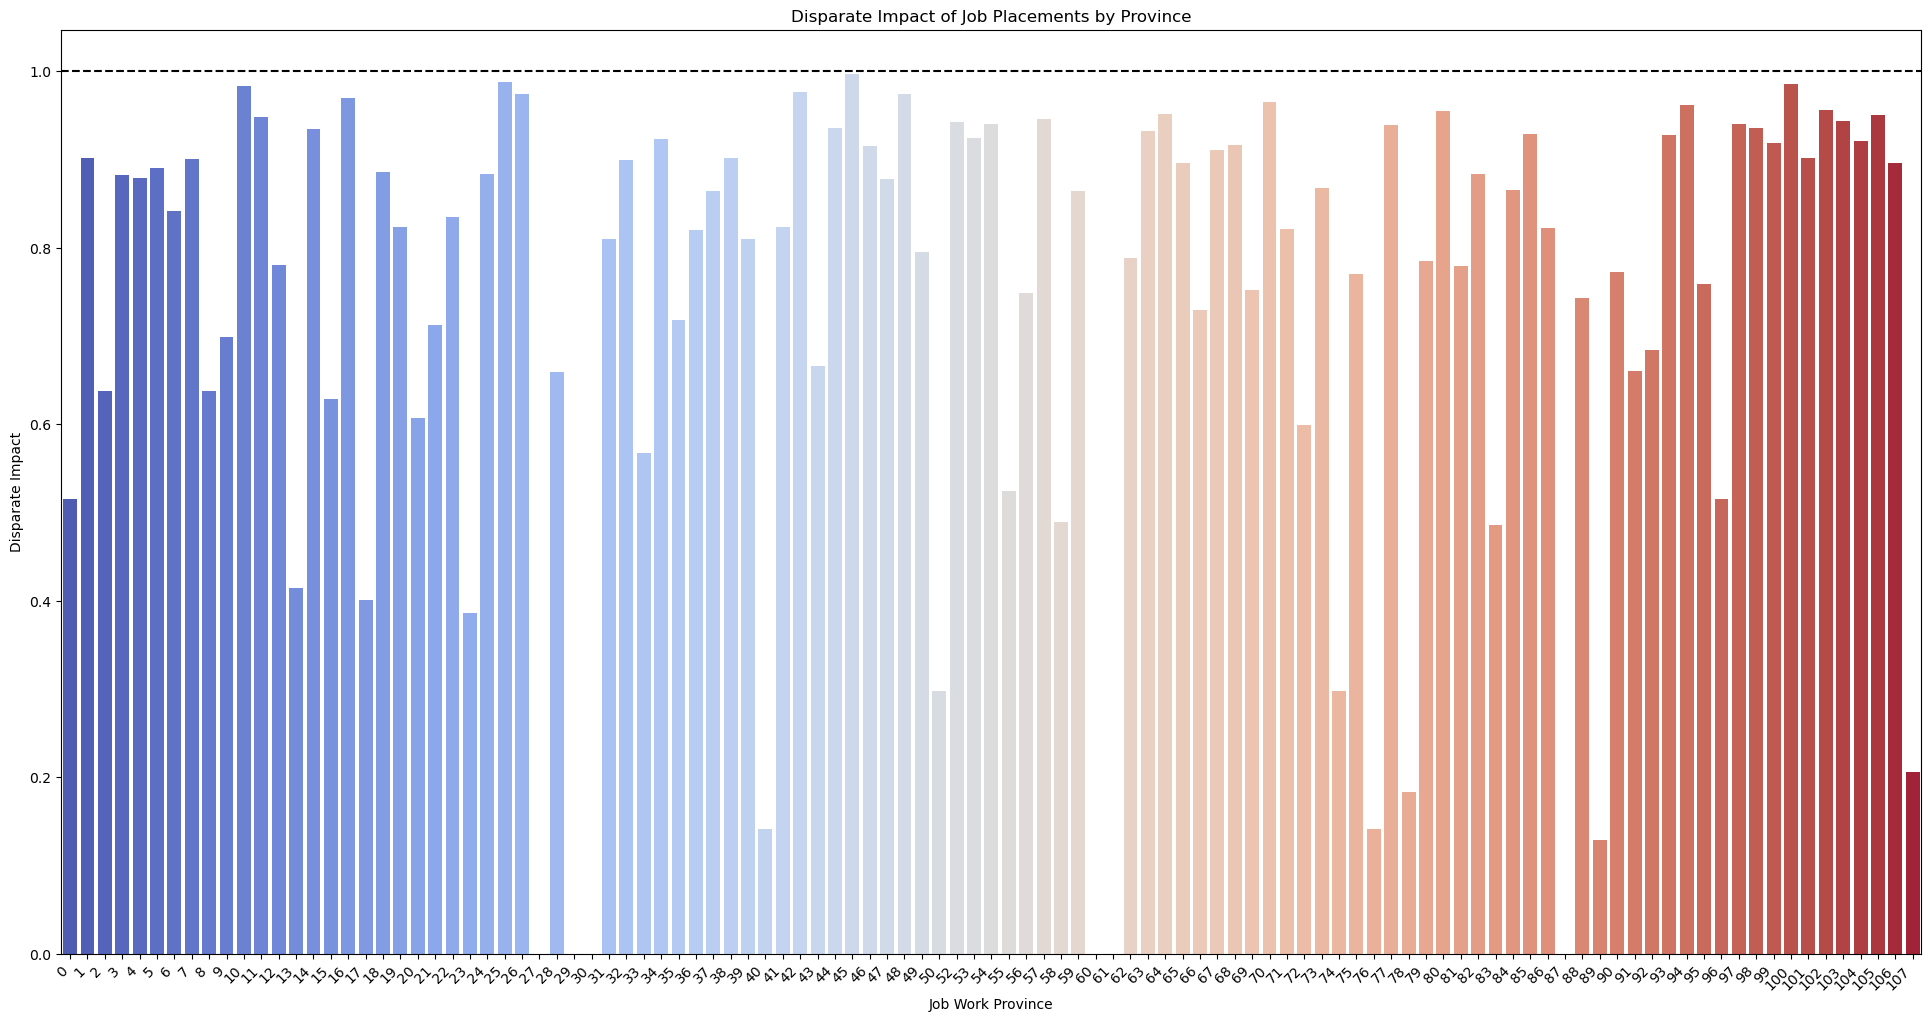

In [661]:
df = rm_df.copy()
# Define privileged and unprivileged groups based on job work province
privileged_groups = [{"job_work_province": 51}]  # Example: Province 0 as privileged (adjust as needed)

# Ensure df contains job_work_province and match_score
if "job_work_province" in df.columns and "match_score" in df.columns:
    # Create unprivileged groups
    unprivileged_groups = [{"job_work_province": r} for r in df["job_work_province"].unique() if r != 51]

    # Define the target variable: whether the candidate was successfully placed (e.g., match score ≥ 80)
    df["successful_placement"] = (df["match_score"] >= 80).astype(int)

    # Keep only necessary columns
    df_province = df[["job_work_province", "successful_placement"]]

    # Convert to AIF360 StandardDataset format
    aif_dataset = StandardDataset(
        df_province,
        label_name="successful_placement",
        favorable_classes=[1],  
        protected_attribute_names=["job_work_province"],  
        privileged_classes=[[51]]  # Province 0 as privileged group
    )

    # Compute fairness metrics
    fairness_results = []
    for region in unprivileged_groups:
        metric = BinaryLabelDatasetMetric(
            aif_dataset, 
            privileged_groups=[{"job_work_province": 51}],  
            unprivileged_groups=[region]
        )

        fairness_results.append({
            "Province": region["job_work_province"],
            "Disparate Impact": metric.disparate_impact(),
            "Statistical Parity Difference": metric.statistical_parity_difference()
        })

    # Convert to DataFrame for visualization
    fairness_df = pd.DataFrame(fairness_results)

    # Sort by Disparate Impact for better visualization
    fairness_df = fairness_df.sort_values(by="Disparate Impact")

    # Plot Disparate Impact by Province
    plt.figure(figsize=(24, 12))
    sns.barplot(x="Province", y="Disparate Impact", data=fairness_df, palette="coolwarm")
    plt.axhline(y=1, color="black", linestyle="--")  # Fairness reference line
    plt.xlabel("Job Work Province")
    plt.ylabel("Disparate Impact")
    plt.title("Disparate Impact of Job Placements by Province")
    plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
    plt.show()

